# Exercise: Predicting Sinusoidal system using RC

2020/11/05 - skim0119

### Contains
- Sparse random Erdos-Renyi network
- RC implemented using nengo

### Difference with original paper

## Table of Contents
* [1. Sinusoidal Data](#1-bullet)
* [2. Sparse random Erdos-Renyi network](#2-bullet)
* [3. Reservoir Computing using Nengo](#3-bullet)
* [4. Training with Tikhonov Regularized Regression](#4-bullet)
* [5. Evaluation - Predict Future Data](#5-bullet)

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.stats as spst
from sklearn.linear_model import Ridge

import nengo

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

### Hyperparameters

In [2]:
# Random Seed
seed = 100

# System Parameters
dim = 3
Amp = np.array([10.0, 8.2, 5.6])  # Amplitude
omega = np.array([np.pi, np.pi/2, np.pi*1.5])  # Frequency
phi = np.array([0, 0, 0])  # Phase Shift
yphi = np.array([3,-2,0])  # Y-shift
dt = 0.02
T_total = 125
T_train = 100
step_total = int(T_total/dt)
step_train = int(T_train/dt)

# RC model Parameters
num_reservoir_neurons = 200  # Dr
spectral_radius = 1.2  # rho

# Training Loss Hyperparameter
beta = 1e-1

## 1. Sinusoidal System <a class="anchor" id="1-bullet"></a>

In [3]:
def multidimension_sinusoidal(_time, dim=3):
    _time = np.asarray(_time)
    return Amp[None,:]*np.sin(omega[None,:]*_time[:,None]+phi[None,:]) + yphi[None,:]

In [4]:
# Data Generate
time = np.arange(0, T_total, dt)
v = multidimension_sinusoidal(time)
xs = v[:,0]

Text(0, 0.5, 'x')

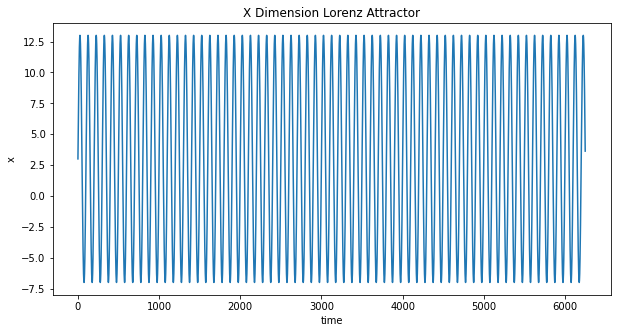

In [5]:
plt.figure(figsize=(10,5))
plt.plot(xs)
plt.title('X Dimension Lorenz Attractor')
plt.xlabel('time')
plt.ylabel('x')

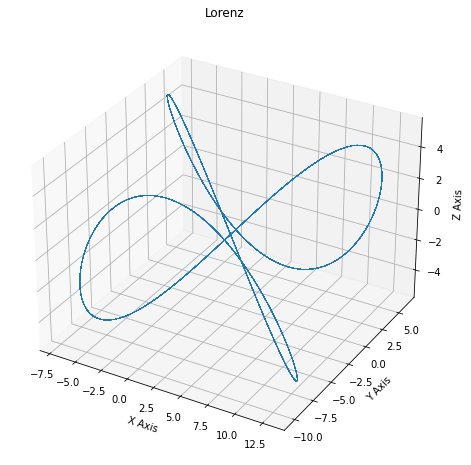

In [6]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.plot(v[:,0], v[:,1], v[:,2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")

ax.set_zlabel("Z Axis")
ax.set_title("Lorenz")

plt.show()

## 2. Sparse random Erdos-Renyi network <a class="anchor" id="2-bullet"></a>

In [7]:
def generate_innerconnection(n, alpha=(-1,1), seed=0, degree=6, spectral_radius=0.9):
    ''' Generate Inner-connection Adjacency Matrix
    Design to generate sparsly connected graph according
    to Erdos-Renyi (ER) Random Graph
    
    Note
    ----
    Density of the graph means the density of connections.
    In scipy sparse package, density means density of non-zero elements.
    
    Parameters
    ----------
    n : number of neuron in reservoir
    alpha : lower/upper bound (equivalent to 'a' in the paper)
        Note that the bound will be re-adjusted to fit spectral radius.
    seed : random seed
    degree : ER graph degree (N*density=degree)
    spectral_radius : spectral radius (equivalent to 'rho' in the paper)
    '''
    
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha = (-alpha, alpha)
    
    rho = min(degree / n, 1.0)  # Density (clip [0,1))
    
    # Random Seed
    np_random = np.random.RandomState(seed)  # Random Generator
    
    # Generate Adjacency (with weights)
    rvs = spst.uniform(alpha[0], alpha[1]).rvs
    A = sps.random(n, n, density=rho, random_state=np_random, data_rvs=rvs)
    
    # Fit Spectral Radius
    E, _ = sps.linalg.eigs(A)
    A *= spectral_radius / np.abs(E).max()  # (TODO) I'm not sure this is 'sparse-friendly' way
    
    return A

def generate_coupler(n, m, alpha=(-1,1), seed=0):
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha = (-alpha, alpha)
    np_random = np.random.RandomState(seed)
    coupler = np_random.uniform(alpha[0], alpha[1], (n, m))
    return coupler

density : 0.03


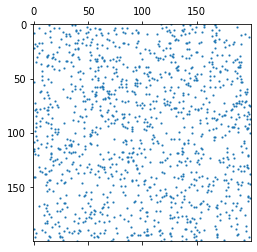

In [8]:
A = generate_innerconnection(num_reservoir_neurons, seed=seed, spectral_radius=spectral_radius)
print(f'density : {A.nnz / np.prod(A.shape)}')
plt.spy(A, markersize=1)

In [9]:
W_in = generate_coupler(num_reservoir_neurons, 3, alpha=1, seed=seed)  # Dr x D

## 3. Reservoir Computing using Nengo <a class="anchor" id="3-bullet"></a>

### Data Preperation

In [10]:
def input_func(time):
    if time >= T_train:
        return np.zeros(3)
    else:
        return multidimension_sinusoidal([time])[0]

### RC Model

In [11]:
network = nengo.Network(label='Lorenz63 Predictor')
with network:
    in_node = nengo.Node(input_func, size_out=3)
    reservoir = nengo.Ensemble(n_neurons=num_reservoir_neurons, dimensions=3, neuron_type=nengo.RectifiedLinear())
    conn_in = nengo.Connection(in_node, reservoir.neurons, synapse=0, transform=W_in)  # Decode
    #conn_res = nengo.Connection(reservoir.neurons, reservoir.neurons,
    #                            synapse=0, transform=A.todense())  # Direct
    tanh = nengo.Node(lambda t, x: np.tanh(x), size_in=num_reservoir_neurons)
    conn_tanh = nengo.Connection(reservoir.neurons, tanh)
    state_probe = nengo.Probe(tanh, synapse=0.1, label='r')

### Pre-trained Simulation

In [12]:
# Pre-trained Simulation
with nengo.Simulator(network, dt=dt, optimize=False, seed=seed) as sim:
    sim.run(T_train)
r_next = sim.data[state_probe]
v_train = multidimension_sinusoidal(sim.trange()+dt)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## 4. Training with Tikhonov Regularized Regression <a class="anchor" id="4-bullet"></a>

In [13]:
clf = Ridge(alpha=beta)
clf.fit(r_next, v_train)
print(f'score (R^2) : {clf.score(r_next, v_train)}')
v_out = clf.predict(r_next)

score (R^2) : 0.9999370122856229


After Training:
2-norm error : 3.8452763122095974
inf-norm error : 0.8885928219199375


Text(0.5, 0, 'time')

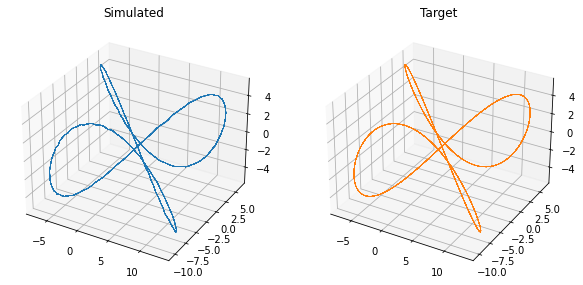

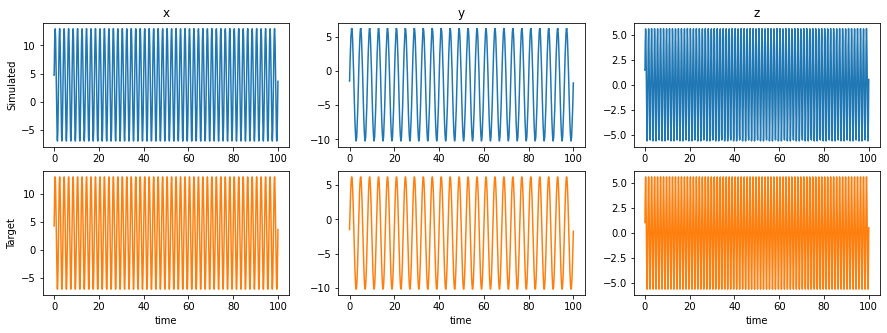

In [14]:
# Plot
print('After Training:')
print(f'2-norm error : {np.linalg.norm(v_out-v_train, 2)}')
print(f'inf-norm error : {np.linalg.norm(v_out-v_train, np.inf)}')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=Axes3D.name)
ax.plot(*v_out.T, lw=0.5)
ax.set_title('Simulated')
ax = fig.add_subplot(122, projection=Axes3D.name)
ax.plot(*v_train.T, 'tab:orange', lw=0.5)
ax.set_title('Target')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(sim.trange(), v_out[:,0])
ax.set_title('x')
ax.set_ylabel('Simulated')
ax = fig.add_subplot(234)
ax.plot(sim.trange(), v_train[:,0], 'tab:orange')
ax.set_ylabel('Target')
ax.set_xlabel('time')
ax = fig.add_subplot(232)
ax.plot(sim.trange(), v_out[:,1])
ax.set_title('y')
ax = fig.add_subplot(235)
ax.plot(sim.trange(), v_train[:,1], 'tab:orange')
ax.set_xlabel('time')
ax = fig.add_subplot(233)
ax.plot(sim.trange(), v_out[:,2])
ax.set_title('z')
ax = fig.add_subplot(236)
ax.plot(sim.trange(), v_train[:,2], 'tab:orange')
ax.set_xlabel('time')

## 5. Evaluation - Predict Future Data <a class="anchor" id="5-bullet"></a>

In [15]:
# Connect v->u
with network:
    def signal_regress(time, x):
        if int(time/dt) < step_train:
            return np.zeros(3)
        else:
            return clf.predict(x[None,:])
    out_node = nengo.Node(signal_regress, size_out=3, size_in=num_reservoir_neurons)
    conn_out = nengo.Connection(tanh, out_node)
    conn_feedback = nengo.Connection(out_node, reservoir.neurons, synapse=0, transform=W_in)  # Decode

In [16]:
# Post-trained Simulation
with nengo.Simulator(network, dt=dt, optimize=False, seed=seed) as sim:
    sim.run(T_total-dt)
r_next = sim.data[state_probe]
vs = multidimension_sinusoidal(sim.trange()+dt)
v_out = clf.predict(r_next)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

After Training - Evaluation:
2-norm error : 457.89468276544136
inf-norm error : 40.5761238455516


Text(0.5, 0, 'time')

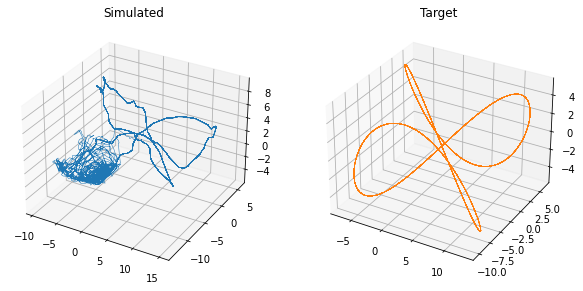

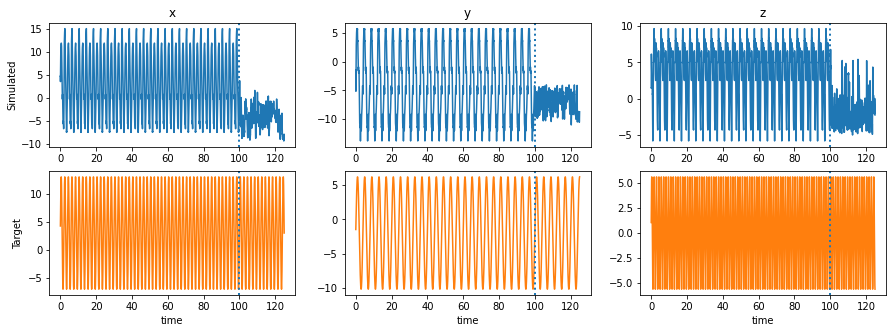

In [17]:
# Plot
print('After Training - Evaluation:')
print(f'2-norm error : {np.linalg.norm(v_out-vs, 2)}')
print(f'inf-norm error : {np.linalg.norm(v_out-vs, np.inf)}')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection=Axes3D.name)
ax.plot(*v_out.T, lw=0.5)
ax.set_title('Simulated')
ax = fig.add_subplot(122, projection=Axes3D.name)
ax.plot(*vs.T, 'tab:orange', lw=0.5)
ax.set_title('Target')

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(231)
ax.plot(sim.trange(), v_out[:,0])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('x')
ax.set_ylabel('Simulated')
ax = fig.add_subplot(234)
ax.plot(sim.trange(), vs[:,0], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_ylabel('Target')
ax.set_xlabel('time')
ax = fig.add_subplot(232)
ax.plot(sim.trange(), v_out[:,1])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('y')
ax = fig.add_subplot(235)
ax.plot(sim.trange(), vs[:,1], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_xlabel('time')
ax = fig.add_subplot(233)
ax.plot(sim.trange(), v_out[:,2])
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_title('z')
ax = fig.add_subplot(236)
ax.plot(sim.trange(), vs[:,2], 'tab:orange')
ax.axvline(T_train, lw=2, ls='dotted')
ax.set_xlabel('time')